In [78]:
import importlib
import sys,os,math,time

import networkx as nx
import geopandas as gpd
import numpy as np
import osmnx as ox
import pandas as pd
import rasterio
import pylab as plt
import json
import pycrs
import seaborn as sns

from shapely.geometry import Point
from rasterio.plot import show, show_hist
from rasterio.mask import mask

import GOSTnet as gn

from pandana.loaders import osm;

from osgeo import gdal, gdalconst, gdal_array
from rasterstats import point_query, zonal_stats
from make_fishnet import make_fishnet

In [79]:
boundary_GDF = ox.gdf_from_place('Kampala',which_result=2)
boundary_GDF
boundary_poly = boundary_GDF.loc[0,'geometry']    # boundary as shapely polygon

In [80]:
pop_raster = rasterio.open('data/kampala_pop_2.tiff')
coords = (pop_raster.bounds[1], pop_raster.bounds[0], pop_raster.bounds[3], pop_raster.bounds[2])

#### 2. Reproject rasters

In [81]:
from osgeo import gdal

In [82]:
path = 'data'
tif_10_path = os.path.join(path, '10yr_Kampala.tif')
tif_50_path = os.path.join(path, '50yr_Kampala.tif')
tif_100_path = os.path.join(path, '100yr_Kampala.tif')

tif_10_proj_path = os.path.join(path, '10yr_Kampala_proj.tif')
tif_50_proj_path = os.path.join(path, '50yr_Kampala_proj.tif')
tif_100_proj_path = os.path.join(path, '100yr_Kampala_proj.tif')

In [7]:
test = rasterio.open(tif_10_path)
test.crs

CRS.from_dict(init='epsg:21096')

In [8]:
# Reproject rasters

input_raster = gdal.Open(tif_10_path)
output_raster = os.path.join(tif_10_proj_path)
gdal.Warp(output_raster,input_raster,dstSRS='EPSG:4326')

input_raster = gdal.Open(tif_50_path)
output_raster = os.path.join(tif_50_proj_path)
gdal.Warp(output_raster,input_raster,dstSRS='EPSG:4326')

input_raster = gdal.Open(tif_100_path)
output_raster = os.path.join(tif_100_proj_path)
gdal.Warp(output_raster,input_raster,dstSRS='EPSG:4326')

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x10d338ab0> >

#### 3. Sample rasters for flood depth

In [83]:
# Create graph
G = ox.graph_from_polygon(boundary_poly, network_type = 'drive')

In [84]:
from shapely.geometry import Point
from shapely.geometry import LineString

node_dict = {}

G2 = G.copy()

for u, data in G2.nodes(data = True):
    node_dict[u] = Point(data['x'],data['y'])
        
for u, v, data in G2.edges(data = True):
    
    if 'Wkt' not in data.keys():
        strt = node_dict[u]
        fini = node_dict[v]
        data['Wkt'] = LineString([strt, fini])
    
    if 'geometry' in data.keys():
        data['Wkt'] = data['geometry']
        data.pop('geometry')

In [85]:
node_gdf = gn.node_gdf_from_graph(G)
edge_gdf = gn.edge_gdf_from_graph(G)

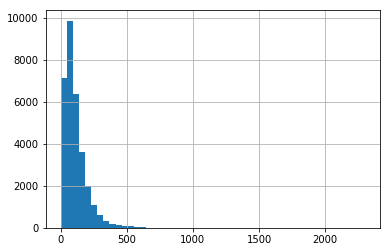

In [86]:
edge_gdf = edge_gdf.sort_values(by = 'length', ascending = False)
edge_gdf['length'].hist(bins = 50)

In [87]:
importlib.reload(gn)
G3 = gn.salt_long_lines(G2,
                       source = 'epsg:4326',
                      target = 'epsg:32636',
                      thresh = 50,
                      factor = 1)

peartree version: 0.6.1 
networkx version: 2.2 
matplotlib version: 3.0.2 
osmnx version: 0.9 
Identified 12151 unique edge(s) longer than 50. 
Beginning new node creation...
80078 new edges added and 23831 removed to bring total edges to 87867
27888 new nodes added to bring total nodes to 41584


In [88]:
G2.number_of_nodes()

13696

In [89]:
G3.number_of_nodes()

41584

In [90]:
G2.number_of_edges()

31620

In [91]:
G3.number_of_edges()

87867

In [92]:
G3 = gn.sample_raster(G3, tif_10_proj_path, property_name = 'flood_depth_10_yr')
G3 = gn.sample_raster(G3, tif_50_proj_path, property_name = 'flood_depth_50_yr')
G3 = gn.sample_raster(G3, tif_100_proj_path, property_name = 'flood_depth_100_yr')

In [93]:
flood_df = gn.node_gdf_from_graph(G3)[['flood_depth_10_yr','flood_depth_50_yr','flood_depth_100_yr']]
flood_df.replace(to_replace=-32767.000000,value=0,inplace=True)

[Text(0, 0.5, 'number of junctions'),
 Text(0.5, 0, 'water depth (meters)'),
 Text(0.5, 1.0, 'Water depths for flooded junctions')]

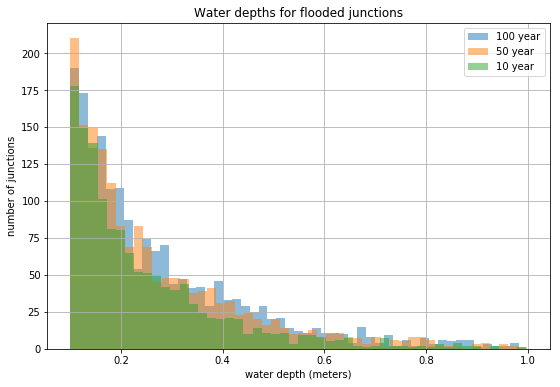

In [94]:
bins = 50

f,ax = plt.subplots(figsize=[9,6])
flood_df.flood_depth_100_yr[(flood_df.flood_depth_100_yr>0) & (flood_df.flood_depth_100_yr<1)].hist(ax=ax,label='100 year',alpha=0.5,bins=bins)
flood_df.flood_depth_50_yr[(flood_df.flood_depth_50_yr>0) & (flood_df.flood_depth_50_yr<1)].hist(ax=ax,label='50 year',alpha=0.5,bins=bins)
flood_df.flood_depth_10_yr[(flood_df.flood_depth_10_yr>0) & (flood_df.flood_depth_10_yr<1)].hist(ax=ax,label='10 year',alpha=0.5,bins=bins)
plt.legend()
ax.set(xlabel="water depth (meters)", ylabel='number of junctions',title = 'Water depths for flooded junctions')


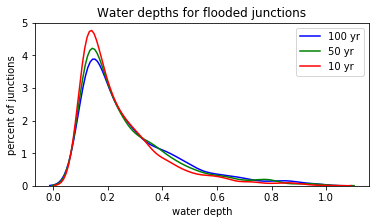

In [95]:
f,ax = plt.subplots(figsize=[6,3])
sns.kdeplot(flood_df.flood_depth_100_yr[(flood_df.flood_depth_100_yr>0) & (flood_df.flood_depth_100_yr<1)],ax = ax, color = 'b')
sns.kdeplot(flood_df.flood_depth_50_yr[(flood_df.flood_depth_50_yr>0) & (flood_df.flood_depth_50_yr<1)],ax=ax, color='g')
sns.kdeplot(flood_df.flood_depth_10_yr[(flood_df.flood_depth_10_yr>0) & (flood_df.flood_depth_10_yr<1)],ax=ax, color='r')
#ax.set_title('Firms in Kampala: What proportion of key business amenities are accessible within {} minutes?'.format(minutes))
plt.legend(['100 yr','50 yr', '10 yr'])
ax.set(xlabel="water depth", ylabel='percent of junctions',title = 'Water depths for flooded junctions');

#### 4. How much of the network does this affect?
Is it a big effect, or are only a small minority of junctions flooded, hence not much of the network degrades?

In [96]:
n_nodes = flood_df.shape[0]
n_edges = edge_gdf.shape[0]

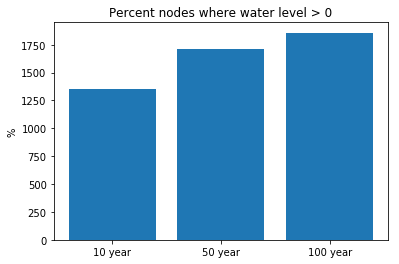

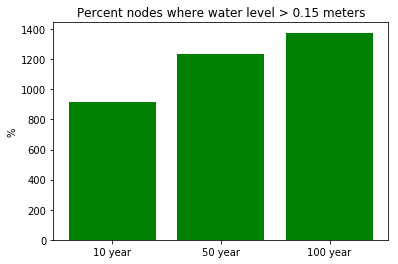

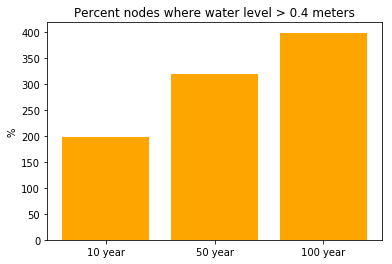

In [97]:
threshold1 = 0.15
threshold2 = 0.4

positive_10yr_percent =  flood_df.flood_depth_10_yr[flood_df.flood_depth_10_yr>0].count()
positive_50yr_percent =  flood_df.flood_depth_50_yr[flood_df.flood_depth_50_yr>0].count()
positive_100yr_percent =  flood_df.flood_depth_100_yr[flood_df.flood_depth_100_yr>0].count()

above_threshold1_10yr_percent =  flood_df.flood_depth_10_yr[flood_df.flood_depth_10_yr>threshold1].count()
above_threshold1_50yr_percent =  flood_df.flood_depth_50_yr[flood_df.flood_depth_50_yr>threshold1].count()
above_threshold1_100yr_percent =  flood_df.flood_depth_100_yr[flood_df.flood_depth_100_yr>threshold1].count()

above_threshold2_10yr_percent =  flood_df.flood_depth_10_yr[flood_df.flood_depth_10_yr>threshold2].count() 
above_threshold2_50yr_percent =  flood_df.flood_depth_50_yr[flood_df.flood_depth_50_yr>threshold2].count() 
above_threshold2_100yr_percent =  flood_df.flood_depth_100_yr[flood_df.flood_depth_100_yr>threshold2].count()

f,ax = plt.subplots()
labels = ['10 year','50 year','100 year']
values = [positive_10yr_percent,positive_50yr_percent,positive_100yr_percent]
plt.bar(labels,values)
ax.set(title = 'Percent nodes where water level > 0', ylabel = '%')

f1,ax1 = plt.subplots()
labels = ['10 year','50 year','100 year']
values = [above_threshold1_10yr_percent,above_threshold1_50yr_percent,above_threshold1_100yr_percent]
ax1.bar(labels,values,color='g')
ax1.set(title = 'Percent nodes where water level > {} meters'.format(threshold1), ylabel = '%')

f2,ax2 = plt.subplots()
labels = ['10 year','50 year','100 year']
values = [above_threshold2_10yr_percent,above_threshold2_50yr_percent,above_threshold2_100yr_percent]
ax2.bar(labels,values,color='orange')
ax2.set(title = 'Percent nodes where water level > {} meters'.format(threshold2), ylabel = '%');


### --> Basically it doesn't affect that many of the nodes.
* Only 4% of nodes have any water at all.
* Only 2% have more than 15 centimeters in a 10-yr event (3% in a 100-yr event)
* Less than 1% are knocked out according to a 40-centimeter threshold.

OK but now more nodes are affected. Will that result in greater increase to journey times?

#### 5. Create the degraded road networks

In [98]:
speed_dict = {  'residential': 20,  # kmph
                'primary': 40, # kmph
                'primary_link':35,
                'motorway':45,
                'motorway_link': 40,
                'trunk': 40,
                'trunk_link':35,
                'secondary': 30, # kmph
                'secondary_link':25,
                'tertiary':30,
                'tertiary_link': 25,
                'unclassified':20, 
                'road':20,
                'crossing':20,
                'living_street':20
                }

In [99]:
G3 = gn.convert_network_to_time(G3, distance_tag = 'length', speed_dict = speed_dict)

In [100]:
gn.example_node(G3)

(6241026052, {'y': 0.3487386, 'x': 32.5916098, 'osmid': 6241026052, 'flood_depth_10_yr': -32767.0, 'flood_depth_50_yr': -32767.0, 'flood_depth_100_yr': -32767.0})


In [101]:
my_flood_depth = 0.15
fail_value = 999999999999999

print("10 year:")
G_flood10 = gn.disrupt_network(G3.copy(), 'flood_depth_10_yr', my_flood_depth, fail_value)

print()
print("50 year:")
G_flood50 = gn.disrupt_network(G3.copy(), 'flood_depth_50_yr', my_flood_depth, fail_value)

print()
print("100 year:")
G_flood100 = gn.disrupt_network(G3.copy(), 'flood_depth_100_yr', my_flood_depth, fail_value)


10 year:
nodes disrupted: 919
edges disrupted: 2684

50 year:
nodes disrupted: 1236
edges disrupted: 3480

100 year:
nodes disrupted: 1377
edges disrupted: 3831


In [103]:
print("15 centimeter threshold:")
print("10-year flood disrupts {:.2f} % of nodes and {:.2f} % of edges".format (919/n_nodes * 100, 2684/n_edges * 100))
print("50-year flood disrupts {:.2f} % of nodes and {:.2f} % of edges".format (1236/n_nodes * 100, 3480/n_edges * 100))
print("100-year flood disrupts {:.2f} % of nodes and {:.2f} % of edges".format (1377/n_nodes * 100, 3831/n_edges * 100))

15 centimeter threshold:
10-year flood disrupts 2.21 % of nodes and 8.49 % of edges
50-year flood disrupts 2.97 % of nodes and 11.01 % of edges
100-year flood disrupts 3.31 % of nodes and 12.12 % of edges


In [48]:
print("25 centimeter threshold:")
print("10-year flood disrupts {:.2f} % of nodes and {:.2f} % of edges".format (297/n_nodes * 100, 921/n_edges * 100))
print("50-year flood disrupts {:.2f} % of nodes and {:.2f} % of edges".format (415/n_nodes * 100, 415/n_edges * 100))
print("100-year flood disrupts {:.2f} % of nodes and {:.2f} % of edges".format (499/n_nodes * 100, 1448/n_edges * 100))

25 centimeter threshold:
10-year flood disrupts 1.25 % of nodes and 2.91 % of edges
50-year flood disrupts 1.75 % of nodes and 1.31 % of edges
100-year flood disrupts 2.10 % of nodes and 4.58 % of edges


In [50]:
print("40 centimeter threshold:")
print("10-year flood disrupts {:.2f} % of nodes and {:.2f} % of edges".format (115/n_nodes * 100, 373/n_edges * 100))
print("50-year flood disrupts {:.2f} % of nodes and {:.2f} % of edges".format (191/n_nodes * 100, 596/n_edges * 100))
print("100-year flood disrupts {:.2f} % of nodes and {:.2f} % of edges".format (238/n_nodes * 100, 727/n_edges * 100))

40 centimeter threshold:
10-year flood disrupts 0.48 % of nodes and 1.18 % of edges
50-year flood disrupts 0.80 % of nodes and 1.88 % of edges
100-year flood disrupts 1.00 % of nodes and 2.30 % of edges


#### 6. Get POIs (destination points)

In [ ]:
# Hospitals

In [137]:
bbox = pop_raster.bounds

amenities_hospital = ['hospital']
amenities_hospital = ['hospital']
POIs_health = osm.node_query(bbox[1],bbox[0],bbox[3],bbox[2],tags = '"amenity"~"{}"'.format('|'.join(amenities_hospital)))

In [138]:
POIs_health = POIs_health[['amenity','name','lat','lon']]

POIs_health = gpd.GeoDataFrame(POIs_health)
POIs_health['geometry'] = (list(zip(POIs_health.lon,POIs_health.lat)))
POIs_health['geometry'] = POIs_health.geometry.apply(lambda x: Point(x))

POIs_health = gpd.sjoin(POIs_health,boundary_GDF,how='inner')

/anaconda3/envs/geo5/lib/python3.6/site-packages/geopandas/tools/sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


In [ ]:
# Business amenities (3300 businesses, stores, gas or mobile phone suppliers, from notebook 4)

In [104]:
POIs_biz = gpd.read_file('data/KM_pois/KM_biz_amenities1')

#### 7. Get origin points
* fishnet of the city
* sample of 307 firms from the employment survey

In [142]:
make_fishnet('grid_KM.shp',coords[1], coords[3], coords[0], coords[2],500,500) # takes xmin, xmax, ymin, ymax

In [105]:
grid=gpd.read_file('grid_KM.shp')

In [106]:
ES_points = gpd.read_file('data/points_ES_clipped')

#### 8. Visualize Os and Ds

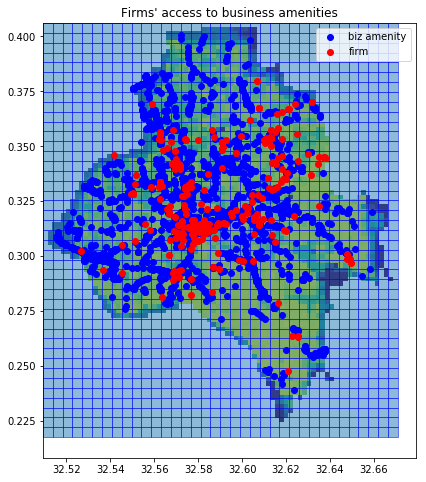

In [107]:
f,ax = plt.subplots(figsize=[8,8])
grid.plot(ax = ax, color=None, edgecolor='b', alpha = 0.5)
show(pop_raster, ax=ax)
POIs_biz.plot(ax=ax, color='b', label = 'biz amenity')
ES_points.plot(ax=ax, color='r', label = 'firm')
plt.title("Firms' access to business amenities")
plt.legend()

#### 9. Calculate travel times

In [118]:
ES_points_nn = gn.pandana_snap(G3, ES_points)
POIs_biz_nn = gn.pandana_snap(G3, POIs_biz)

In [119]:
list_of_nearest_nodes_ES = list(ES_points_nn.NN)
list_of_nearest_nodes_POIs_biz = list(POIs_biz_nn.NN)

In [110]:
def calculate_OD(G, origins, destinations, fail_value, weight = 'time'):
    #### Function for generating an origin: destination matrix  ####
    # REQUIRED: G - a graph containing one or more nodes
    #           fail_value - the value to return if the trip cannot be completed (implies some sort of disruption / disconnected nodes)
    #           origins - a list of the node IDs to treat as origins points
    #           destinations - a list of the node IDs to treat as destination points
    # OPTIONAL: weight - use edge weight of 'time' unless otherwise specified
    # RETURNS:  a numpy matrix of format OD[o][d] = shortest time possible
    # -------------------------------------------------------------------------#

    OD = np.zeros((len(origins), len(destinations)))

    for o in range(0, len(origins)):
        origin = origins[o]
        results_dict = nx.single_source_dijkstra_path_length(G, origin, cutoff = None, weight = weight)

        for d in range(0, len(destinations)):
            destination = destinations[d]
            if destination in results_dict.keys():
                OD[o][d] = results_dict[destination]
            else:
                OD[o][d] = fail_value

    return OD

In [120]:
baseline_OD_bizaccess = calculate_OD(G3, list_of_nearest_nodes_ES, list_of_nearest_nodes_POIs_biz, fail_value, weight='time')

In [121]:
ES_points_nn = gn.pandana_snap(G_flood10, ES_points)
POIs_biz_nn = gn.pandana_snap(G_flood10, POIs_biz)

list_of_nearest_nodes_ES = list(ES_points_nn.NN)
list_of_nearest_nodes_POIs_biz = list(POIs_biz_nn.NN)

flood_OD_bizaccess_10yr = calculate_OD(G_flood10, list_of_nearest_nodes_ES, list_of_nearest_nodes_POIs_biz, fail_value, weight='time')


/Users/nicholasjones/Desktop/code/network_analysis/GOSTnet.py:1572: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  G_tree = spatial.KDTree(node_gdf[['x','y']].as_matrix())
/Users/nicholasjones/Desktop/code/network_analysis/GOSTnet.py:1574: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances, indices = G_tree.query(in_df[['x','y']].as_matrix())


In [122]:
ES_points_nn = gn.pandana_snap(G_flood50, ES_points)
POIs_biz_nn = gn.pandana_snap(G_flood50, POIs_biz)

list_of_nearest_nodes_ES = list(ES_points_nn.NN)
list_of_nearest_nodes_POIs_biz = list(POIs_biz_nn.NN)

flood_OD_bizaccess_50yr = calculate_OD(G_flood50, list_of_nearest_nodes_ES, list_of_nearest_nodes_POIs_biz, fail_value, weight='time')


In [123]:
ES_points_nn = gn.pandana_snap(G_flood100, ES_points)
POIs_biz_nn = gn.pandana_snap(G_flood100, POIs_biz)

list_of_nearest_nodes_ES = list(ES_points_nn.NN)
list_of_nearest_nodes_POIs_biz = list(POIs_biz_nn.NN)

flood_OD_bizaccess_100yr = calculate_OD(G_flood100, list_of_nearest_nodes_ES, list_of_nearest_nodes_POIs_biz, fail_value, weight='time')

In [124]:
baseline_OD_bizaccess_df = pd.DataFrame(baseline_OD_bizaccess, index = list_of_nearest_nodes_ES, columns = list_of_nearest_nodes_POIs_biz)
flood_OD_bizaccess_10yr_df = pd.DataFrame(flood_OD_bizaccess_10yr)
flood_OD_bizaccess_50yr_df = pd.DataFrame(flood_OD_bizaccess_50yr)
flood_OD_bizaccess_100yr_df = pd.DataFrame(flood_OD_bizaccess_100yr)

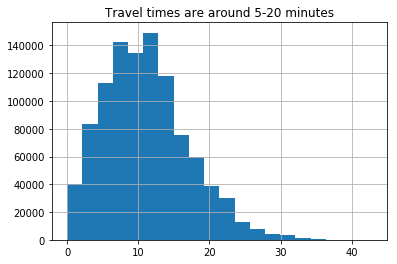

In [125]:
pd.Series(baseline_OD_bizaccess.ravel()/60).hist(bins=20)
plt.title("Travel times are around 5-20 minutes");

#### 10. How many amenities accessible within x minutes?

In [115]:
minutes = 10
threshold = minutes * 60       # Set a threshold (minutes * 60)

In [126]:
baseline_number_reachable = baseline_OD_bizaccess_df[baseline_OD_bizaccess_df < threshold].count(axis=1)
flood_10_number_reachable = flood_OD_bizaccess_10yr_df[flood_OD_bizaccess_10yr_df < threshold].count(axis=1)
flood_50_number_reachable = flood_OD_bizaccess_50yr_df[flood_OD_bizaccess_50yr_df < threshold].count(axis=1)
flood_100_number_reachable = flood_OD_bizaccess_100yr_df[flood_OD_bizaccess_100yr_df < threshold].count(axis=1)

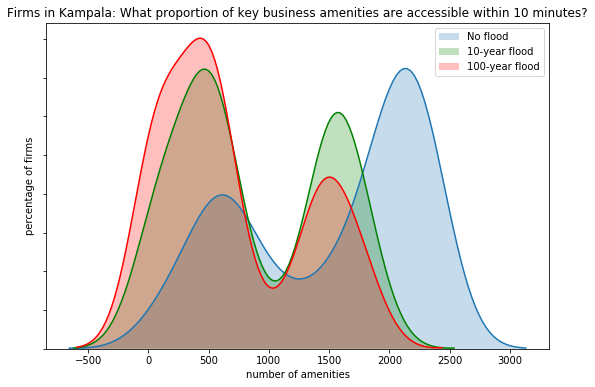

In [127]:
f,ax = plt.subplots(figsize=[9,6])
ax = sns.kdeplot(baseline_number_reachable,shade=True)

sns.kdeplot(flood_10_number_reachable, ax=ax, color='g',shade=True)
#sns.kdeplot(flood_50_number_reachable, ax=ax, color='y',shade=True)
sns.kdeplot(flood_100_number_reachable, ax=ax, color='r',shade=True)
ax.set_title('Firms in Kampala: What proportion of key business amenities are accessible within {} minutes?'.format(minutes))
plt.legend(['No flood','10-year flood','100-year flood'])
ax.set_yticklabels([])
ax.set(xlabel="number of amenities", ylabel='percentage of firms');